# Modeling
### goals
* get feature importances from grid search rather than random forest

## Import packages

In [6]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import preprocessing, svm
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error

#Use to ignore convergence warnings
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import __version__ as sklearn_version
import datetime

import joblib

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
# np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

## Load X and y data sets

In [7]:
# import X and y training and test sets

X = pd.read_csv('../../data/train_test/X_alt')
y = pd.read_csv('../../data/train_test/y_alt')

X_train = pd.read_csv('../../data/train_test/X_train_74_26')

X_test = pd.read_csv('../../data/train_test/X_test_74_26')

y_train = pd.read_csv('../../data/train_test/y_train_alt_74_26')

y_test = pd.read_csv('../../data/train_test/y_test_alt+74_26')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42)

In [9]:
rf_pipe = Pipeline([('scaler', StandardScaler()),
                    ('rf', RandomForestRegressor(random_state=42))])

In [10]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('rf', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'rf': RandomForestRegressor(random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'mse',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [11]:
n_est = np.arange(50, 200)
rf_param_grid = {
    'rf__n_estimators':n_est,
    'scaler':[None],
    'rf__max_features':['auto', 'sqrt', 'log2'],
    'rf__criterion':['mae']
}



In [13]:
rf_grid = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['mae'],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88...
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 18

In [17]:
display(rf_grid.best_params_)
rf_grid.best_score_

{'rf__criterion': 'mae',
 'rf__max_features': 'auto',
 'rf__n_estimators': 81,
 'scaler': None}

0.294691271713666

In [18]:
rf_best = rf_grid.best_estimator_
rf_best.score(X_test, y_test)

0.3144261029356381

In [39]:
rf_mean_score = rf_grid.cv_results_['mean_test_score']
rf_std_score = rf_grid.cv_results_['std_test_score']
rf_n_estimators = [n for n in rf_grid.cv_results_['param_rf__n_estimators']]
best_n_val = rf_best.named_steps.rf.n_estimators

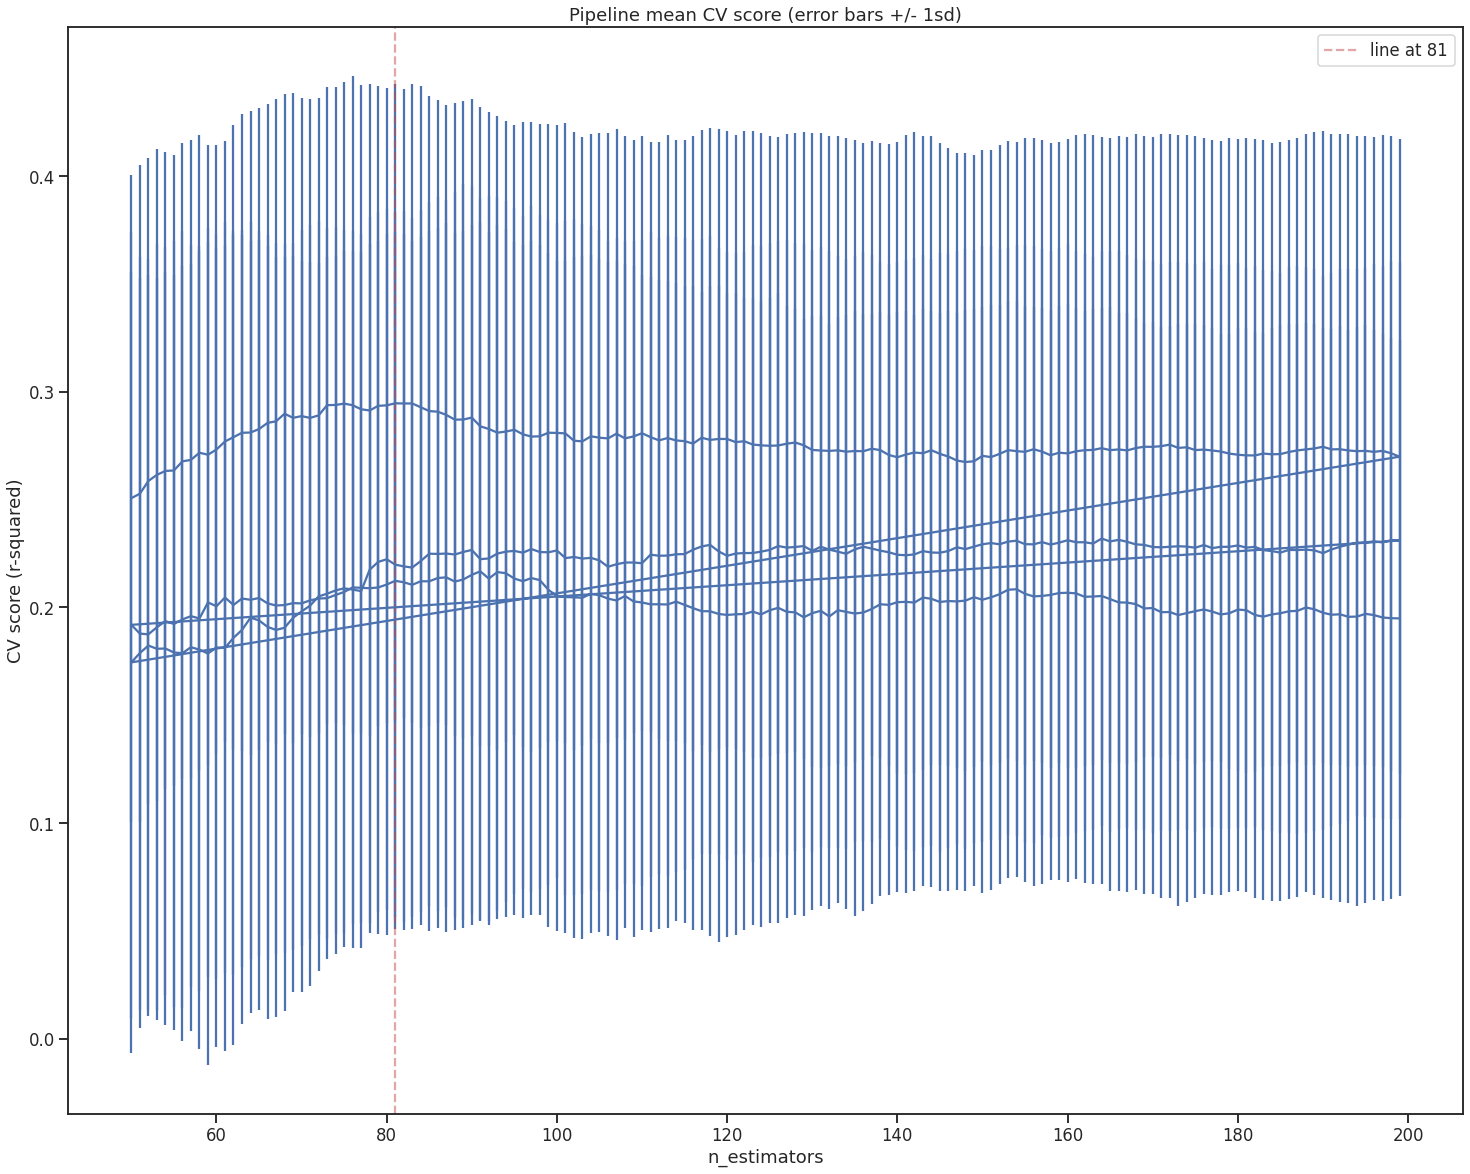

In [45]:
plt.subplots(figsize=(25, 20))
plt.errorbar(rf_n_estimators, rf_mean_score, yerr=rf_std_score)
plt.axvline(x=best_n_val, c='r', ls='--', alpha=.5, label='line at 81')
plt.xlabel('n_estimators')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.legend();

In [38]:
feat_imp = rf_best.named_steps.rf.feature_importances_
feat_imp_series = pd.Series(feat_imp, index=X_train.columns).sort_values(ascending=False)
feat_imp_series.head(20)

NH_FEMALE_ratio_2018                                           0.020221
HBAC_FEMALE_ratio_2017_2018_diff                               0.018797
HAA_MALE_ratio_2018_2019_diff                                  0.015577
HAA_MALE_ratio_2017_2019_diff                                  0.013840
HWA_MALE_ratio_2018                                            0.013674
HWAC_MALE_ratio_2018                                           0.012558
HBAC_FEMALE_ratio_2017_2019_diff                               0.010394
BACH_TOT_2017_2019_diff                                        0.009801
HAA_MALE_2018_2019_diff                                        0.009130
GRAD_TOT_ratio_2018                                            0.008843
HBA_FEMALE_ratio_2017_2019_diff                                0.008178
NAC_FEMALE_2018_2019_diff                                      0.007629
NHIA_FEMALE_ratio_2017_2019_diff                               0.007055
Personal income (thousands of dollars) 2018_2019_pct_change    0

In [30]:
feat_imp_series.index[:30]


Index(['NH_FEMALE_ratio_2018', 'HBAC_FEMALE_ratio_2017_2018_diff',
       'HAA_MALE_ratio_2018_2019_diff', 'HAA_MALE_ratio_2017_2019_diff',
       'HWA_MALE_ratio_2018', 'HWAC_MALE_ratio_2018',
       'HBAC_FEMALE_ratio_2017_2019_diff', 'BACH_TOT_2017_2019_diff',
       'HAA_MALE_2018_2019_diff', 'GRAD_TOT_ratio_2018',
       'HBA_FEMALE_ratio_2017_2019_diff', 'NAC_FEMALE_2018_2019_diff',
       'NHIA_FEMALE_ratio_2017_2019_diff',
       'Personal income (thousands of dollars) 2018_2019_pct_change',
       'HAAC_MALE_ratio_2017_2019_diff', 'IAC_FEMALE_ratio_2017_2018_diff',
       'HS_TOT_ratio_2017_2018_pct_change', 'HS_TOT_ratio_2018_2019_diff',
       'HS_TOT_2017_2018_pct_change', 'HAAC_MALE_ratio_2017_2018_diff',
       'NHIA_FEMALE_ratio_2017_2018_diff', 'IAC_FEMALE_2017_2018_pct_change',
       'NH_FEMALE_ratio_2017_2018_pct_change', '90% CI LB 5-17 fam_2018',
       'H_FEMALE_ratio_2017_2018_pct_change',
       'NH_FEMALE_ratio_2017_2019_pct_change', 'AQI_2017_2018_diff',
     

In [37]:
feat_imp_series.tail(50)

TOT_FEMALE_2017_2018_pct_change                                1.943149e-05
IAC_MALE_2017_2018_diff                                        1.918202e-05
WA_MALE_2017_2019_pct_change                                   1.887007e-05
NHNA_MALE_2017_2019_pct_change                                 1.881298e-05
HIAC_MALE_2017_2018_pct_change                                 1.837524e-05
BAC_FEMALE_ratio_2017_2018_pct_change                          1.768308e-05
WAC_MALE_2018                                                  1.714641e-05
HIA_MALE_2017_2018_diff                                        1.695298e-05
90% CI UB percent_2017_2018_diff                               1.692705e-05
NHAAC_FEMALE_2017_2018_diff                                    1.520049e-05
NHAA_MALE_2017_2018_pct_change                                 1.513258e-05
TOM_FEMALE_2018                                                1.506517e-05
90% CI UB percent_2017_2019_pct_change                         1.486439e-05
WAC_MALE_201

<AxesSubplot:>

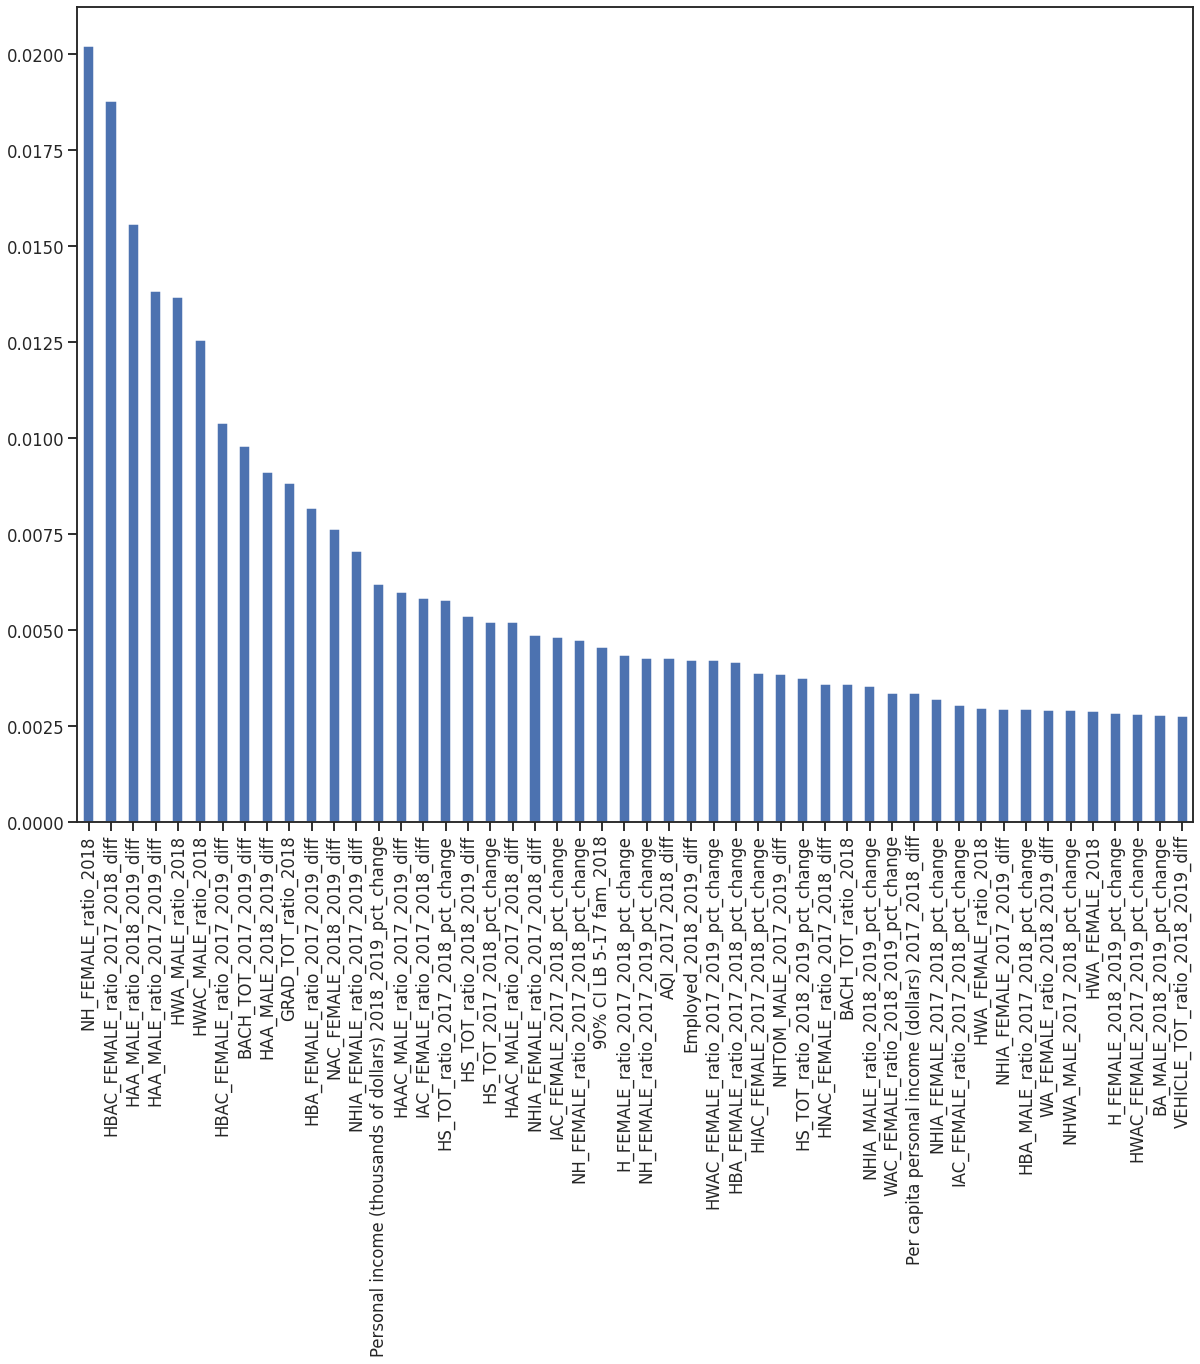

In [51]:
plt.figure(figsize=(20,15))
feat_imp_series[:50].plot(kind='bar')

In [53]:
y_test_sorted = y_test.sort_values(by='AQI_2019')
y_test_sorted[:10]

,AQI_2019
104,5.637931
55,8.003115
154,8.885246
100,9.564103
197,9.807692
164,9.907473
167,10.378882
203,10.503937
148,10.592179
120,10.868347


In [54]:
rf_y_pred = rf_best.predict(X_test)
rf_y_pred = pd.DataFrame({'AQI_2019':rf_y_pred.tolist()}, index=y_test.index)
rf_y_pred = rf_y_pred.reindex(index=y_test_sorted.index)
rf_y_pred[:10]

,AQI_2019
104,15.878962
55,12.732439
154,14.634815
100,15.654934
197,13.672525
164,16.856658
167,15.123993
203,15.611935
148,18.326878
120,14.191238


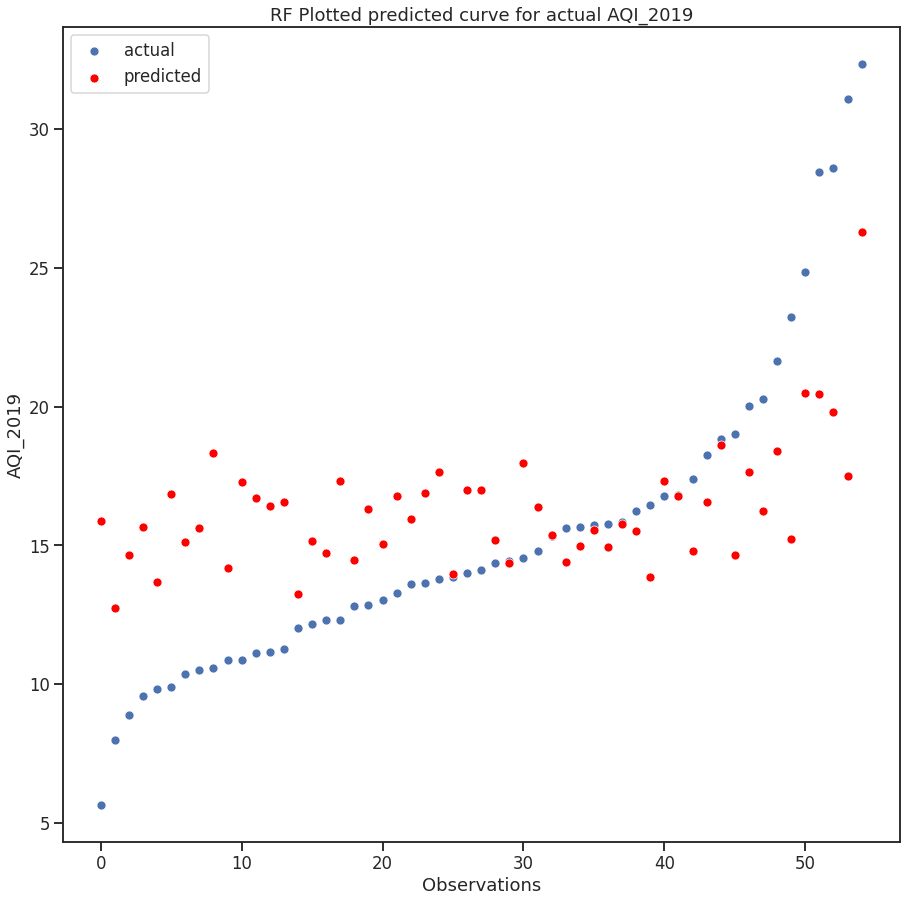

In [55]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=y_test_sorted, x=np.arange(0,55), y='AQI_2019', label='actual')
sns.scatterplot(data=rf_y_pred, x=np.arange(0,55), y='AQI_2019', color='red', label='predicted')
# sns.lineplot(data=lr_y_pred, color='red', label='predicted')
# sns.lineplot(data=y_test_sorted, color='blue', label='actual')

plt.title('RF Plotted predicted curve for actual AQI_2019')
plt.xlabel('Observations')
plt.show();

In [65]:
# pd.set_option('display.max_columns', None)
with pd.option_context('display.max_rows', 2000):
    display(feat_imp_series)


NH_FEMALE_ratio_2018                                           2.022089e-02
HBAC_FEMALE_ratio_2017_2018_diff                               1.879736e-02
HAA_MALE_ratio_2018_2019_diff                                  1.557746e-02
HAA_MALE_ratio_2017_2019_diff                                  1.384009e-02
HWA_MALE_ratio_2018                                            1.367387e-02
HWAC_MALE_ratio_2018                                           1.255830e-02
HBAC_FEMALE_ratio_2017_2019_diff                               1.039377e-02
BACH_TOT_2017_2019_diff                                        9.801077e-03
HAA_MALE_2018_2019_diff                                        9.129733e-03
GRAD_TOT_ratio_2018                                            8.843436e-03
HBA_FEMALE_ratio_2017_2019_diff                                8.178465e-03
NAC_FEMALE_2018_2019_diff                                      7.628925e-03
NHIA_FEMALE_ratio_2017_2019_diff                               7.055287e-03
Personal inc

In [66]:
feat_imp_series.index.tolist()

['NH_FEMALE_ratio_2018',
 'HBAC_FEMALE_ratio_2017_2018_diff',
 'HAA_MALE_ratio_2018_2019_diff',
 'HAA_MALE_ratio_2017_2019_diff',
 'HWA_MALE_ratio_2018',
 'HWAC_MALE_ratio_2018',
 'HBAC_FEMALE_ratio_2017_2019_diff',
 'BACH_TOT_2017_2019_diff',
 'HAA_MALE_2018_2019_diff',
 'GRAD_TOT_ratio_2018',
 'HBA_FEMALE_ratio_2017_2019_diff',
 'NAC_FEMALE_2018_2019_diff',
 'NHIA_FEMALE_ratio_2017_2019_diff',
 'Personal income (thousands of dollars) 2018_2019_pct_change',
 'HAAC_MALE_ratio_2017_2019_diff',
 'IAC_FEMALE_ratio_2017_2018_diff',
 'HS_TOT_ratio_2017_2018_pct_change',
 'HS_TOT_ratio_2018_2019_diff',
 'HS_TOT_2017_2018_pct_change',
 'HAAC_MALE_ratio_2017_2018_diff',
 'NHIA_FEMALE_ratio_2017_2018_diff',
 'IAC_FEMALE_2017_2018_pct_change',
 'NH_FEMALE_ratio_2017_2018_pct_change',
 '90% CI LB 5-17 fam_2018',
 'H_FEMALE_ratio_2017_2018_pct_change',
 'NH_FEMALE_ratio_2017_2019_pct_change',
 'AQI_2017_2018_diff',
 'Employed_2018_2019_diff',
 'HWAC_FEMALE_ratio_2017_2019_pct_change',
 'HBA_FEMALE

In [67]:
# save rf model with all attributes
path = r'../../model/rf_with_all_attributes.sav'
joblib.dump(rf_best, path)


['../../model/rf_with_all_attributes.sav']

In [69]:
rf_best_100_cols = feat_imp_series[:100].index.tolist()
X_train_reduced = X_train[rf_best_100_cols]
X_test_reduced = X_test[rf_best_100_cols]

In [70]:
rf_best_100_cols

['NH_FEMALE_ratio_2018',
 'HBAC_FEMALE_ratio_2017_2018_diff',
 'HAA_MALE_ratio_2018_2019_diff',
 'HAA_MALE_ratio_2017_2019_diff',
 'HWA_MALE_ratio_2018',
 'HWAC_MALE_ratio_2018',
 'HBAC_FEMALE_ratio_2017_2019_diff',
 'BACH_TOT_2017_2019_diff',
 'HAA_MALE_2018_2019_diff',
 'GRAD_TOT_ratio_2018',
 'HBA_FEMALE_ratio_2017_2019_diff',
 'NAC_FEMALE_2018_2019_diff',
 'NHIA_FEMALE_ratio_2017_2019_diff',
 'Personal income (thousands of dollars) 2018_2019_pct_change',
 'HAAC_MALE_ratio_2017_2019_diff',
 'IAC_FEMALE_ratio_2017_2018_diff',
 'HS_TOT_ratio_2017_2018_pct_change',
 'HS_TOT_ratio_2018_2019_diff',
 'HS_TOT_2017_2018_pct_change',
 'HAAC_MALE_ratio_2017_2018_diff',
 'NHIA_FEMALE_ratio_2017_2018_diff',
 'IAC_FEMALE_2017_2018_pct_change',
 'NH_FEMALE_ratio_2017_2018_pct_change',
 '90% CI LB 5-17 fam_2018',
 'H_FEMALE_ratio_2017_2018_pct_change',
 'NH_FEMALE_ratio_2017_2019_pct_change',
 'AQI_2017_2018_diff',
 'Employed_2018_2019_diff',
 'HWAC_FEMALE_ratio_2017_2019_pct_change',
 'HBA_FEMALE

In [72]:
rf_best.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', None),
                ('rf',
                 RandomForestRegressor(criterion='mae', n_estimators=81,
                                       random_state=42))])>

In [71]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('rf', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'rf': RandomForestRegressor(random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'mse',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [ ]:
n_est = np.arange(1,300)
rf_reduced_params = {'scaler': [None],
                     'rf__criterion':['mae'],
                     'rf__n_estimators:':n_est
                     }